In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import datetime

#Disable GPU
#tf.config.set_visible_devices([], 'GPU')

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Rescaling,Resizing,RandomFlip,RandomRotation,BatchNormalization,Dropout
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.regularizers import L2
from tensorflow.keras import Input
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print(tf.__version__)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10495566321734751882
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6665732096
locality {
  bus_id: 1
  links {
  }
}
incarnation: 38937956811417719
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080 SUPER, pci bus id: 0000:09:00.0, compute capability: 7.5"
xla_global_id: 416903419
]
2.11.0


In [2]:
IMG_SIZE=150
BATCH_SIZE=16

TRAIN_DATA="../dogscats/train/"
VALIDATION_DATA="../dogscats/valid/"

def plot_sample(data):
    class_names = data.class_names
    plt.figure(figsize=(20, 20))
    for images, labels in data.take(1):
        for i in range(20):
            ax = plt.subplot(10, 10, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

def plot_single_image(data, index):     
    class_names = data.class_names
    for images, labels in data.take(1):
        plt.imshow(images[index].numpy().astype("uint8"))
        plt.title(class_names[labels[index]])
        
def plot_accuracy(history):
    fig, (plt1, plt2) = plt.subplots(1, 2)

    fig.set_figheight(8)
    fig.set_figwidth(20)

    plt1.set_title('model accuracy')
    plt1.set_ylabel('accuracy')
    plt1.set_xlabel('epoch')
    plt1.legend(['train', 'test'], loc='upper left')
    plt1.plot(history['accuracy'])
    plt1.plot(history['val_accuracy'])

    plt2.set_title('model loss')
    plt2.set_ylabel('loss')
    plt2.set_xlabel('epoch')
    plt2.legend(['train', 'test'], loc='upper left')
    plt2.plot(history['loss'])
    plt2.plot(history['val_loss'])
    
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label    

## Load dataset

In [3]:
train_data=tf.keras.utils.image_dataset_from_directory(
    TRAIN_DATA,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

validation_data=tf.keras.utils.image_dataset_from_directory(
    VALIDATION_DATA,
    validation_split=None,
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),    
    batch_size=BATCH_SIZE
)

print(train_data.class_names)
print(validation_data.class_names)

Found 23000 files belonging to 2 classes.
Using 18400 files for training.
Found 2000 files belonging to 2 classes.
['cats', 'dogs']
['cats', 'dogs']


## Optimize model

In [4]:
def model_builder(hp):
    data_augmentation = Sequential([
        RandomFlip("horizontal_and_vertical"),
        RandomRotation(0.4),
    ])
    
    hp_conv2d_layer_1 = hp.Int('units_conv2d_1', min_value=32, max_value=320, step=32)
    hp_conv2d_layer_2 = hp.Int('units_conv2d_2', min_value=32, max_value=320, step=32)
    
    hp_dense_size_1 = hp.Int('units_dense_1', min_value=32, max_value=320, step=32)
    hp_dense_size_2 = hp.Int('units_dense_2', min_value=32, max_value=320, step=32)

    model=Sequential([
        data_augmentation,
        Conv2D(hp_conv2d_layer_1, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Conv2D(hp_conv2d_layer_2, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(hp_dense_size_1, activation='relu'),
        Dense(hp_dense_size_2, activation='relu'),
        Dense(2, activation='softmax')
    ])    
   
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-4, 1e-5])

    model.compile(
        optimizer=Adam(learning_rate=hp_learning_rate),
        loss=SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )

    model.build(input_shape=(BATCH_SIZE, IMG_SIZE, IMG_SIZE, 3))
    
    return model

In [5]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=20,
                     factor=3,
                     directory='model_optimize',
                     project_name='dogs_cats')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(train_data.map(process), epochs=5, validation_data=validation_data.map(process))

Trial 30 Complete [00h 15m 24s]
val_accuracy: 0.7429999709129333

Best val_accuracy So Far: 0.7429999709129333
Total elapsed time: 02h 35m 17s
INFO:tensorflow:Oracle triggered exit


In [6]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [7]:
print(best_hps.get('units_conv2d_1'))
print(best_hps.get('units_conv2d_2'))
print(best_hps.get('units_dense_1'))
print(best_hps.get('units_dense_2'))
print(best_hps.get('learning_rate'))

224
256
64
128
0.0001


## Train best model

In [8]:
model = tuner.hypermodel.build(best_hps)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 148, 148, 224)     6272      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 74, 74, 224)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 72, 72, 256)       516352    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 36, 36, 256)      0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 331776)           

In [9]:
history = model.fit(
    train_data.map(process), 
    epochs=40,
    validation_data=validation_data.map(process)
)

Epoch 1/40
1150/1150 [==============================] - 50s 41ms/step - loss: 0.6193 - accuracy: 0.6482 - val_loss: 0.5700 - val_accuracy: 0.6975
Epoch 2/40
1150/1150 [==============================] - 47s 40ms/step - loss: 0.5689 - accuracy: 0.7021 - val_loss: 0.5661 - val_accuracy: 0.7040
Epoch 3/40
1150/1150 [==============================] - 48s 42ms/step - loss: 0.5392 - accuracy: 0.7245 - val_loss: 0.5438 - val_accuracy: 0.7350
Epoch 4/40
1150/1150 [==============================] - 47s 41ms/step - loss: 0.5202 - accuracy: 0.7422 - val_loss: 0.5294 - val_accuracy: 0.7415
Epoch 5/40
1150/1150 [==============================] - 47s 41ms/step - loss: 0.5021 - accuracy: 0.7559 - val_loss: 0.5176 - val_accuracy: 0.7460
Epoch 6/40
1150/1150 [==============================] - 47s 41ms/step - loss: 0.4848 - accuracy: 0.7680 - val_loss: 0.5184 - val_accuracy: 0.7520
Epoch 7/40
1150/1150 [==============================] - 47s 40ms/step - loss: 0.4742 - accuracy: 0.7723 - val_loss: 0.5124 -

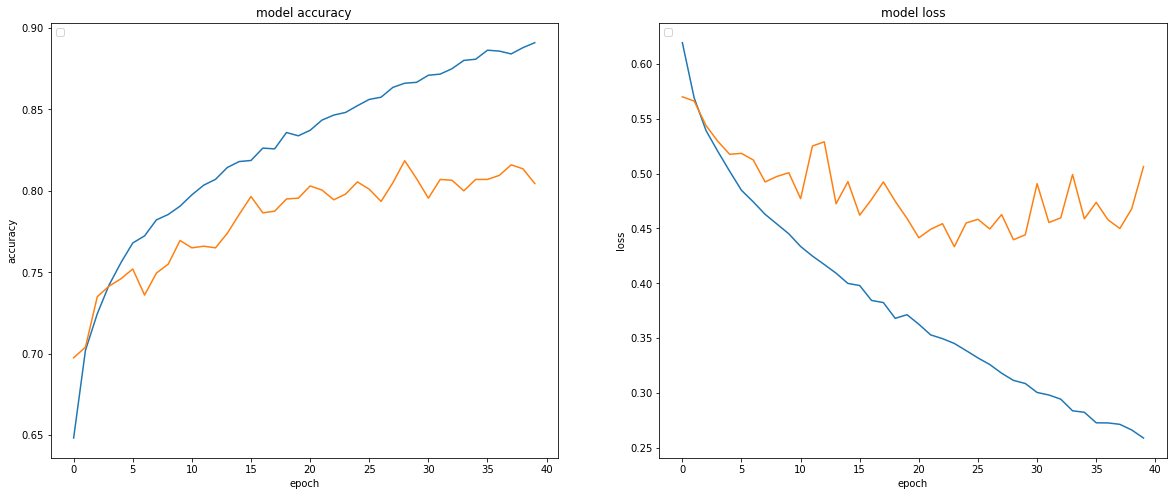

In [10]:
plot_accuracy(history.history)

## Test predictions

In [11]:
def show_prediction(image_path):
    test_img=tf.keras.utils.load_img(
        image_path,
        target_size=(IMG_SIZE, IMG_SIZE),
    )
    plt.imshow(test_img)
    input_arr = tf.keras.utils.img_to_array(test_img)
    input_arr = np.array([input_arr])
    predictions=model.predict(np.array(input_arr)/255.0)
    print("Cat: %0.2f Dog: %0.2f" % (predictions[0][0]*100, predictions[0][1]*100))

1/1 [==============================] - 0s 146ms/step
Cat: 21.20 Dog: 78.80


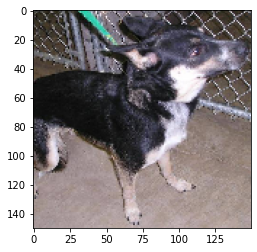

In [12]:
show_prediction("../dogscats/test1/test/8395.jpg")

1/1 [==============================] - 0s 13ms/step
Cat: 99.63 Dog: 0.37


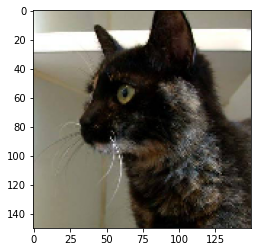

In [13]:
show_prediction("../dogscats/test1/test/5.jpg")

1/1 [==============================] - 0s 16ms/step
Cat: 98.26 Dog: 1.74


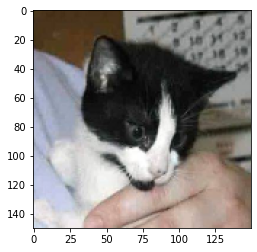

In [14]:
show_prediction("../dogscats/test1/test/50.jpg")

1/1 [==============================] - 0s 13ms/step
Cat: 9.47 Dog: 90.53


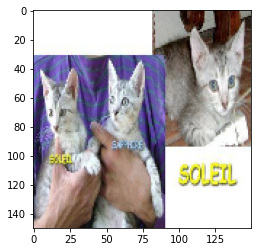

In [15]:
show_prediction("../dogscats/test1/test/25.jpg")

1/1 [==============================] - 0s 14ms/step
Cat: 80.49 Dog: 19.51


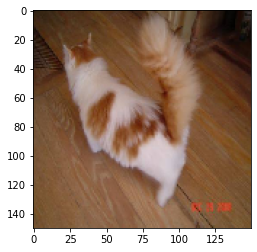

In [16]:
show_prediction("../dogscats/test1/test/2137.jpg")

## Save model

In [17]:
#tf.saved_model.save(model, './models')
model.save("./models/dogscatsmodel.h5")

In [18]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('./models/dogscatsmodel.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpd1vf4qox/assets


INFO:tensorflow:Assets written to: /tmp/tmpd1vf4qox/assets
